In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np
import progressbar as pb

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = UnityEnvironment(file_name="./Reacher_Windows_x86_64_1_agent/Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size, fc1_size=128, fc2_size=64, log_std=-0.5):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        
        self.action_mean = nn.Linear(fc2_size, action_size)
        self.action_mean.weight.data.mul_(0.1)
        self.action_mean.bias.data.mul_(0.0)

        self.action_log_std = nn.Parameter(torch.ones(1, action_size) * log_std)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        
        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std

    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        action_mean, action_log_std, action_std = self.forward(state)
        action = torch.clamp(torch.normal(action_mean, action_std), -1, 1)
        
        return action, action_log_std
    
class Value(nn.Module):
    """
        Critic network that estimates a Value Function used as a baseline
    """
    def __init__(self, state_size, action_size=1, fc1_size=128, fc2_size=64):
        super(Value, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def estimate(self, state):
        state = torch.from_numpy(state).float().to(device)
        return self.forward(state)

In [6]:
policy_network   = Policy(state_size=state_size, action_size=action_size).to(device)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=5e-4)

value_network    = Value(state_size=state_size, action_size=1).to(device)
value_criterion  = nn.MSELoss()
value_optimizer  = optim.Adam(value_network.parameters(), lr=5e-4)

In [7]:
from utils import unroll_trajectory, rewards_to_go

def interact(actions):
    env_info = env.step(actions)[brain_name]
    return env_info.vector_observations, env_info.rewards, env_info.local_done

def reset():
    env_info = env.reset(train_mode=True)[brain_name]
    return env_info.vector_observations
    

In [8]:
import progressbar as pb
from collections import deque

def advantage_estimate(states, rewards, next_states, value_network, n_agents, t_max, gamma=0.995):
    current_values = value_network.estimate(states).reshape(n_agents, t_max).detach().cpu().numpy()
    next_values = value_network.estimate(next_states).reshape(n_agents, t_max).detach().cpu().numpy()
    rewards = rewards.reshape(n_agents, t_max)
    
    advantages = rewards + gamma * np.nan_to_num(next_values) - current_values
    return advantages

def ppo_clip_objective(policy_network, states, advantages, old_log_probs, epsilon=0.1):
    
    _, new_log_probs = policy_network.act(states)
    ratio = new_log_probs / old_log_probs.detach()
    advantages = torch.from_numpy(advantages).float().to(device)
    
    min_term = torch.min(
        ratio*advantages[:,:,None], 
        torch.clamp(ratio, 1-epsilon, 1+epsilon)*advantages[:,:,None]
    ).mean(1).mean(0).mean()
    
    return min_term

def ppo_clip(t_max, n_episodes=1000, print_every=100, n_policy_iterations=20, n_value_iterations=1000):
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(n_episodes):
        
        trajectory = unroll_trajectory(interact, reset, policy_network, num_agents, t_max=t_max)
        
        mean_rewards = trajectory['rewards'].sum(axis=1).mean()
        scores_deque.append(mean_rewards)
        scores.append(mean_rewards)
        
        states    = trajectory['states']
        rewards   = rewards_to_go(trajectory['rewards'])
        log_probs = trajectory['log_probs']
        
        next_states = np.roll(states, -1, axis=2)
        next_states[:,-1,:] = np.nan

        advantages = advantage_estimate(states, rewards, next_states, value_network, num_agents, t_max)
        
        for i in range(0, trajectory['num_episodes']):
            policy_optimizer.zero_grad()
            policy_loss = -ppo_clip_objective(policy_network, states, advantages, log_probs)
            policy_loss.backward()
            policy_optimizer.step()
            
        for i in range(0, n_value_iterations):
            value_optimizer.zero_grad()
            target = value_network.estimate(states).reshape(num_agents, -1)
            objective = torch.from_numpy(rewards).float().to(device).reshape(num_agents, -1)
            value_loss = value_criterion(target, objective)
            value_loss.backward()
            value_optimizer.step()
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=30.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
            
        timer.update(i_episode)
        
    return scores

In [9]:
scores = ppo_clip(t_max=1000, n_episodes=300)

Episode 0	Average Score: 0.00


Episode 100	Average Score: 0.03


Episode 200	Average Score: 0.02


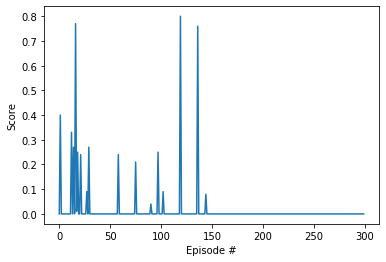

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [6]:
import numpy as np

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9] ])

a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [17]:
a.mean(axis=1)

array([2., 5., 8.])